## Stock Prediction using LSTM Networks
Machine learning has found its application niche in many industries and fields, including Wall Street. Here, we will use an LSTM network to predict the trend and stock price for Apple. Long Short Term Memory (LSTM) networks are a subset of the overall Recurrent Neural Networks (RNN) neural network class. What is special about LSTM network elements is that they are capable of learning long-term dependencies and are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn. A great source of information regarding LSTM's can be found at Andre karpathy’s <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/" target="_blank">blog</a>, which is considered one of the best resources on LSTM networks. 

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import array_equal
import random as rn
from tensorflow import set_random_seed
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [2]:
# set the random seed
sd = 777
np.random.seed(sd)
rn.seed(sd)
set_random_seed(sd)

In [3]:
# load & preview the dataset
df = pd.read_csv('data/AAPL.csv', engine='python')
df.head()

,date,open,high,low,close,volume
0,1/9/14,71.6912,71.6991,70.1900,70.3432,69905199
1,1/10/14,70.7773,70.9045,69.6341,69.8740,76320664
2,1/13/14,69.4767,71.1274,69.4728,70.2398,94860843
3,1/14/14,70.5663,71.6820,70.4928,71.6374,83734371
4,1/15/14,72.5722,73.4481,72.3284,73.0757,98472619


In [4]:
df.tail()

,date,open,high,low,close,volume
1253,1/2/19,154.89,158.8500,154.23,157.92,37039737
1254,1/3/19,143.98,145.7200,142.00,142.19,91312195
1255,1/4/19,144.53,148.5499,143.80,148.26,58607070
1256,1/7/19,148.70,148.8300,145.90,147.93,54777764
1257,1/8/19,149.56,151.8200,148.52,150.75,41025314


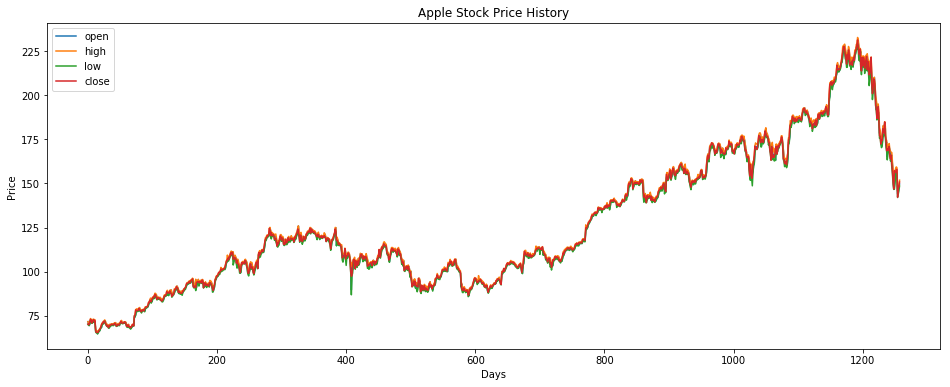

In [5]:
# plot the price data
plt.figure(figsize=(16,6))
plt.plot(df["open"])
plt.plot(df["high"])
plt.plot(df["low"])
plt.plot(df["close"])
plt.title('Apple Stock Price History')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['open','high','low','close'], loc='upper left')
plt.show()

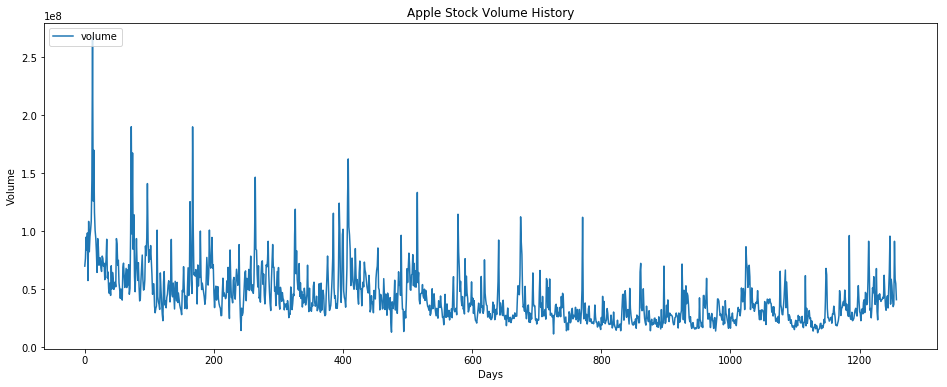

In [6]:
# plot the volume data
plt.figure(figsize=(16,6))
plt.plot(df["volume"])
plt.title('Apple Stock Volume History')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['volume'], loc='upper left')
plt.show()

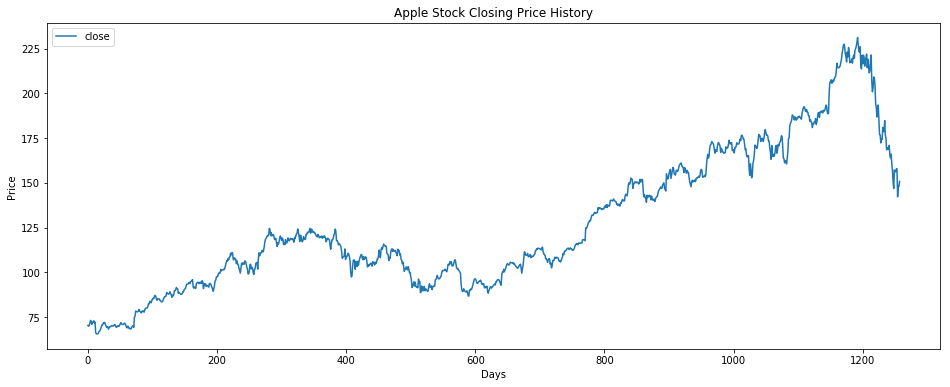

In [7]:
# plot just the closing price
plt.figure(figsize=(16,6))
plt.plot(df["close"])
plt.title('Apple Stock Closing Price History')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['close'], loc='upper left')
plt.show()

In [8]:
# check dataset for null values
print("Checking for null values:\n", df.isnull().sum())

Checking for null values:
 date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [9]:
# split the dataset into training and testing sets
train, test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Training set size: %d, Test set size: %d" % (len(train), len(test)))

Training set size: 1006, Test set size: 252


In [10]:
# normalize the data
train_cols = ["open", "high", "low", "close", "volume"]
train = train.loc[:, train_cols].values
test = test.loc[:, train_cols].values
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [11]:
# transform dataset into supervised learning problem
def build_timeseries(data, time_steps, output_index):
    # output_index is the index of the column containing your desired output value
    # total number of time series samples is len(data) -  time_steps
    dim_0 = data.shape[0] - time_steps
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = data[i:time_steps+i]
        y[i] = data[time_steps+i, output_index]
    print("Input time series shape:", x.shape)
    print("Output time series shape:", y.shape)
    return x, y

In [12]:
# create training & test sets for LSTM
time_steps = 60
X_train, y_train = build_timeseries(train_scaled, time_steps, 3)
X_temp, y_temp = build_timeseries(test_scaled, time_steps, 3) 

Input time series shape: (946, 60, 5)
Output time series shape: (946,)
Input time series shape: (192, 60, 5)
Output time series shape: (192,)


In [13]:
# trim training & test sets to be divisible by the batch size
def trim_dataset(dataset, batch_size):
    no_of_rows_drop = dataset.shape[0] % batch_size
    if (no_of_rows_drop > 0):
        return dataset[: -no_of_rows_drop]
    else:
        return dataset    

In [14]:
# trim datasets to fit batch size
batch_size = 10
X_val, X_test = np.split(X_temp, 2)
y_val, y_test = np.split(y_temp, 2)
X_train = trim_dataset(X_train, batch_size)
y_train = trim_dataset(y_train, batch_size)
X_val = trim_dataset(X_val, batch_size)
y_val = trim_dataset(y_val, batch_size)
X_test = trim_dataset(X_test, batch_size)
y_test = trim_dataset(y_test, batch_size)

In [15]:
# review dataset shapes
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)
print("Validation input shape:", X_test.shape)
print("Validation output shape:", y_test.shape)

Training input shape: (940, 60, 5)
Training output shape: (940,)
Test input shape: (90, 60, 5)
Test output shape: (90,)
Validation input shape: (90, 60, 5)
Validation output shape: (90,)


In [16]:
# define the LSTM model
def lstm_model(X, batch_size):
    inputs = Input(batch_shape=(batch_size, X.shape[1], X.shape[2]))
    L1 = LSTM(192, stateful=True, kernel_initializer='random_uniform', activity_regularizer=regularizers.l2(10e-6))(inputs)
    D1 = Dropout(0.5)(L1)
    L2 = Dense(32, activation='relu')(D1)   
    output = Dense(1)(L2)
    model = Model(inputs=inputs, outputs=output)
    return model    

In [17]:
# create the LSTM model
model = lstm_model(X_train, batch_size)
optimizer = RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (10, 60, 5)               0         
_________________________________________________________________
lstm_1 (LSTM)                (10, 192)                 152064    
_________________________________________________________________
dropout_1 (Dropout)          (10, 192)                 0         
_________________________________________________________________
dense_1 (Dense)              (10, 32)                  6176      
_________________________________________________________________
dense_2 (Dense)              (10, 1)                   33        
Total params: 158,273
Trainable params: 158,273
Non-trainable params: 0
_________________________________________________________________


In [18]:
# define save weights checkpoint
filepath="Stock_Prediction_LSTM_weights-{val_loss:.4f}-{epoch: 02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [19]:
# train the model
nb_epochs = 500
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size, shuffle=False, validation_data=(X_val, y_val), callbacks=[checkpoint]).history

Train on 940 samples, validate on 90 samples
Epoch 1/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0145 - val_loss: 0.0046
Epoch 2/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 3/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/500
940/940 [==============================] - 6s 6ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 5/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 6/500
940/940 [==============================] - 4s 4ms/step - loss: 0.0035 - val_loss: 0.0071
Epoch 7/500
940/940 [==============================] - 4s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 8/500
940/940 [==============================] - 4s 4ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 9/500
940/940 [==============================] - 4s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/500
940/940 [========================

940/940 [==============================] - 4s 4ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 38/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 39/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 40/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 41/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 42/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 43/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 44/500
940/940 [==============================] - 4s 5ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 45/500
940/940 [==============================] - 4s 5ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 46/500
940/940 [==============================] - 4s 5ms/step - loss: 0.0015 - val_loss: 

Epoch 75/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 76/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 77/500
940/940 [==============================] - 5s 6ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 78/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 79/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 80/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 81/500
940/940 [==============================] - 4s 5ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 82/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 83/500
940/940 [==============================] - 4s 5ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 84/500
940/940 [==============================] - 5s 5ms/step - loss: 0.0011

Epoch 112/500
940/940 [==============================] - 4s 4ms/step - loss: 9.4690e-04 - val_loss: 0.0013
Epoch 113/500
940/940 [==============================] - 4s 4ms/step - loss: 9.5985e-04 - val_loss: 0.0014
Epoch 114/500
940/940 [==============================] - 4s 4ms/step - loss: 8.7299e-04 - val_loss: 0.0022
Epoch 115/500
940/940 [==============================] - 4s 4ms/step - loss: 9.0029e-04 - val_loss: 0.0025
Epoch 116/500
940/940 [==============================] - 4s 4ms/step - loss: 8.7431e-04 - val_loss: 0.0011
Epoch 117/500
940/940 [==============================] - 5s 5ms/step - loss: 9.1348e-04 - val_loss: 0.0025
Epoch 118/500
940/940 [==============================] - 5s 5ms/step - loss: 8.8975e-04 - val_loss: 0.0015
Epoch 119/500
940/940 [==============================] - 5s 5ms/step - loss: 9.4886e-04 - val_loss: 0.0013
Epoch 120/500
940/940 [==============================] - 6s 6ms/step - loss: 9.0231e-04 - val_loss: 0.0014
Epoch 121/500
940/940 [==============

940/940 [==============================] - 13s 14ms/step - loss: 7.0209e-04 - val_loss: 9.4012e-04
Epoch 148/500
940/940 [==============================] - 12s 12ms/step - loss: 7.6846e-04 - val_loss: 9.8753e-04
Epoch 149/500
940/940 [==============================] - 9s 9ms/step - loss: 7.3307e-04 - val_loss: 0.0010
Epoch 150/500
940/940 [==============================] - 8s 9ms/step - loss: 7.2418e-04 - val_loss: 0.0012
Epoch 151/500
940/940 [==============================] - 9s 9ms/step - loss: 8.4580e-04 - val_loss: 0.0013
Epoch 152/500
940/940 [==============================] - 9s 9ms/step - loss: 7.4040e-04 - val_loss: 0.0012
Epoch 153/500
940/940 [==============================] - 9s 10ms/step - loss: 8.0769e-04 - val_loss: 0.0011
Epoch 154/500
940/940 [==============================] - 9s 9ms/step - loss: 8.0184e-04 - val_loss: 9.6025e-04
Epoch 155/500
940/940 [==============================] - 9s 9ms/step - loss: 7.7250e-04 - val_loss: 9.1327e-04
Epoch 156/500
940/940 [=======

Epoch 182/500
940/940 [==============================] - 8s 8ms/step - loss: 7.2025e-04 - val_loss: 8.6208e-04
Epoch 183/500
940/940 [==============================] - 8s 8ms/step - loss: 7.0776e-04 - val_loss: 8.6837e-04
Epoch 184/500
940/940 [==============================] - 8s 8ms/step - loss: 6.8758e-04 - val_loss: 0.0012
Epoch 185/500
940/940 [==============================] - 7s 8ms/step - loss: 6.7968e-04 - val_loss: 9.1194e-04
Epoch 186/500
940/940 [==============================] - 8s 8ms/step - loss: 6.4312e-04 - val_loss: 8.5049e-04
Epoch 187/500
940/940 [==============================] - 8s 8ms/step - loss: 6.8124e-04 - val_loss: 8.2500e-04
Epoch 188/500
940/940 [==============================] - 8s 8ms/step - loss: 5.9690e-04 - val_loss: 0.0013
Epoch 189/500
940/940 [==============================] - 8s 8ms/step - loss: 6.8821e-04 - val_loss: 9.0446e-04
Epoch 190/500
940/940 [==============================] - 8s 8ms/step - loss: 6.7501e-04 - val_loss: 0.0012
Epoch 191/500

Epoch 218/500
940/940 [==============================] - 6s 7ms/step - loss: 6.0012e-04 - val_loss: 8.0885e-04
Epoch 219/500
940/940 [==============================] - 6s 6ms/step - loss: 5.9362e-04 - val_loss: 7.3942e-04
Epoch 220/500
940/940 [==============================] - 4s 5ms/step - loss: 6.2117e-04 - val_loss: 8.7835e-04
Epoch 221/500
940/940 [==============================] - 5s 5ms/step - loss: 6.0753e-04 - val_loss: 7.3555e-04
Epoch 222/500
940/940 [==============================] - 5s 5ms/step - loss: 6.1852e-04 - val_loss: 0.0020
Epoch 223/500
940/940 [==============================] - 5s 6ms/step - loss: 5.5107e-04 - val_loss: 0.0011
Epoch 224/500
940/940 [==============================] - 4s 4ms/step - loss: 6.6176e-04 - val_loss: 0.0010
Epoch 225/500
940/940 [==============================] - 4s 4ms/step - loss: 6.5070e-04 - val_loss: 0.0011
Epoch 226/500
940/940 [==============================] - 5s 5ms/step - loss: 5.5091e-04 - val_loss: 7.3015e-04
Epoch 227/500
940

Epoch 254/500
940/940 [==============================] - 5s 5ms/step - loss: 6.0301e-04 - val_loss: 6.8413e-04
Epoch 255/500
940/940 [==============================] - 5s 5ms/step - loss: 5.5255e-04 - val_loss: 0.0015
Epoch 256/500
940/940 [==============================] - 4s 5ms/step - loss: 5.5168e-04 - val_loss: 9.1656e-04
Epoch 257/500
940/940 [==============================] - 6s 7ms/step - loss: 5.1325e-04 - val_loss: 6.8260e-04
Epoch 258/500
940/940 [==============================] - 7s 8ms/step - loss: 5.6401e-04 - val_loss: 6.9986e-04
Epoch 259/500
940/940 [==============================] - 6s 6ms/step - loss: 5.4526e-04 - val_loss: 8.4354e-04
Epoch 260/500
940/940 [==============================] - 6s 6ms/step - loss: 5.3095e-04 - val_loss: 0.0015
Epoch 261/500
940/940 [==============================] - 5s 5ms/step - loss: 5.9657e-04 - val_loss: 0.0014
Epoch 262/500
940/940 [==============================] - 5s 5ms/step - loss: 5.4295e-04 - val_loss: 0.0010
Epoch 263/500
940

Epoch 291/500
940/940 [==============================] - 5s 5ms/step - loss: 5.2002e-04 - val_loss: 9.8111e-04
Epoch 292/500
940/940 [==============================] - 5s 6ms/step - loss: 5.5631e-04 - val_loss: 0.0022
Epoch 293/500
940/940 [==============================] - 6s 6ms/step - loss: 4.9827e-04 - val_loss: 0.0015
Epoch 294/500
940/940 [==============================] - 5s 5ms/step - loss: 5.3062e-04 - val_loss: 0.0013
Epoch 295/500
940/940 [==============================] - 5s 5ms/step - loss: 5.5230e-04 - val_loss: 0.0012
Epoch 296/500
940/940 [==============================] - 5s 5ms/step - loss: 5.7250e-04 - val_loss: 0.0010
Epoch 297/500
940/940 [==============================] - 5s 5ms/step - loss: 5.3734e-04 - val_loss: 0.0013
Epoch 298/500
940/940 [==============================] - 5s 5ms/step - loss: 5.7784e-04 - val_loss: 0.0013
Epoch 299/500
940/940 [==============================] - 4s 5ms/step - loss: 5.1754e-04 - val_loss: 0.0015
Epoch 300/500
940/940 [==========

Epoch 329/500
940/940 [==============================] - 4s 5ms/step - loss: 5.4658e-04 - val_loss: 0.0016
Epoch 330/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9296e-04 - val_loss: 0.0012
Epoch 331/500
940/940 [==============================] - 4s 5ms/step - loss: 5.5342e-04 - val_loss: 0.0012
Epoch 332/500
940/940 [==============================] - 4s 4ms/step - loss: 5.7888e-04 - val_loss: 0.0018
Epoch 333/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9769e-04 - val_loss: 0.0021
Epoch 334/500
940/940 [==============================] - 4s 4ms/step - loss: 5.1554e-04 - val_loss: 0.0011
Epoch 335/500
940/940 [==============================] - 4s 4ms/step - loss: 4.8254e-04 - val_loss: 9.2602e-04
Epoch 336/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3896e-04 - val_loss: 9.7690e-04
Epoch 337/500
940/940 [==============================] - 4s 5ms/step - loss: 5.2274e-04 - val_loss: 0.0012
Epoch 338/500
940/940 [======

Epoch 367/500
940/940 [==============================] - 4s 5ms/step - loss: 5.1469e-04 - val_loss: 0.0024
Epoch 368/500
940/940 [==============================] - 5s 5ms/step - loss: 4.9494e-04 - val_loss: 0.0016
Epoch 369/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3599e-04 - val_loss: 0.0019
Epoch 370/500
940/940 [==============================] - 4s 5ms/step - loss: 5.1125e-04 - val_loss: 0.0011
Epoch 371/500
940/940 [==============================] - 4s 5ms/step - loss: 5.0937e-04 - val_loss: 0.0014
Epoch 372/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3540e-04 - val_loss: 7.0739e-04
Epoch 373/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3123e-04 - val_loss: 0.0021
Epoch 374/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9940e-04 - val_loss: 0.0014
Epoch 375/500
940/940 [==============================] - 4s 5ms/step - loss: 5.1029e-04 - val_loss: 0.0016
Epoch 376/500
940/940 [==========

940/940 [==============================] - 4s 5ms/step - loss: 4.8911e-04 - val_loss: 0.0019
Epoch 406/500
940/940 [==============================] - 4s 5ms/step - loss: 5.6727e-04 - val_loss: 8.5228e-04
Epoch 407/500
940/940 [==============================] - 4s 5ms/step - loss: 5.5306e-04 - val_loss: 0.0017
Epoch 408/500
940/940 [==============================] - 4s 5ms/step - loss: 5.2421e-04 - val_loss: 0.0013
Epoch 409/500
940/940 [==============================] - 4s 5ms/step - loss: 5.2101e-04 - val_loss: 0.0012
Epoch 410/500
940/940 [==============================] - 5s 5ms/step - loss: 4.5102e-04 - val_loss: 0.0021
Epoch 411/500
940/940 [==============================] - 4s 5ms/step - loss: 5.2811e-04 - val_loss: 0.0016
Epoch 412/500
940/940 [==============================] - 4s 5ms/step - loss: 4.8275e-04 - val_loss: 0.0011
Epoch 413/500
940/940 [==============================] - 5s 5ms/step - loss: 5.5419e-04 - val_loss: 0.0013
Epoch 414/500
940/940 [========================

Epoch 443/500
940/940 [==============================] - 4s 4ms/step - loss: 5.7222e-04 - val_loss: 0.0010
Epoch 444/500
940/940 [==============================] - 4s 4ms/step - loss: 5.3207e-04 - val_loss: 0.0019
Epoch 445/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9958e-04 - val_loss: 0.0016
Epoch 446/500
940/940 [==============================] - 4s 5ms/step - loss: 5.1635e-04 - val_loss: 0.0021
Epoch 447/500
940/940 [==============================] - 5s 5ms/step - loss: 5.1053e-04 - val_loss: 0.0018
Epoch 448/500
940/940 [==============================] - 4s 5ms/step - loss: 5.2514e-04 - val_loss: 0.0014
Epoch 449/500
940/940 [==============================] - 4s 5ms/step - loss: 5.0287e-04 - val_loss: 0.0019
Epoch 450/500
940/940 [==============================] - 4s 5ms/step - loss: 5.4581e-04 - val_loss: 9.1541e-04
Epoch 451/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9325e-04 - val_loss: 0.0022
Epoch 452/500
940/940 [==========

940/940 [==============================] - 4s 5ms/step - loss: 4.5730e-04 - val_loss: 7.3742e-04
Epoch 482/500
940/940 [==============================] - 4s 5ms/step - loss: 4.6102e-04 - val_loss: 9.9727e-04
Epoch 483/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3058e-04 - val_loss: 0.0011
Epoch 484/500
940/940 [==============================] - 5s 5ms/step - loss: 4.9392e-04 - val_loss: 0.0011
Epoch 485/500
940/940 [==============================] - 4s 5ms/step - loss: 5.3286e-04 - val_loss: 8.4652e-04
Epoch 486/500
940/940 [==============================] - 4s 5ms/step - loss: 4.7297e-04 - val_loss: 0.0012
Epoch 487/500
940/940 [==============================] - 4s 5ms/step - loss: 5.0785e-04 - val_loss: 0.0012
Epoch 488/500
940/940 [==============================] - 4s 5ms/step - loss: 4.9210e-04 - val_loss: 0.0016
Epoch 489/500
940/940 [==============================] - 5s 5ms/step - loss: 5.3803e-04 - val_loss: 0.0015
Epoch 490/500
940/940 [================

In [20]:
# evaluate the training set
test_val = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Test Model Stats: ")
print("Loss: %.6f" % (test_val))

90/90 [==============================] - 0s 2ms/step
Test Model Stats: 
Loss: 0.001845


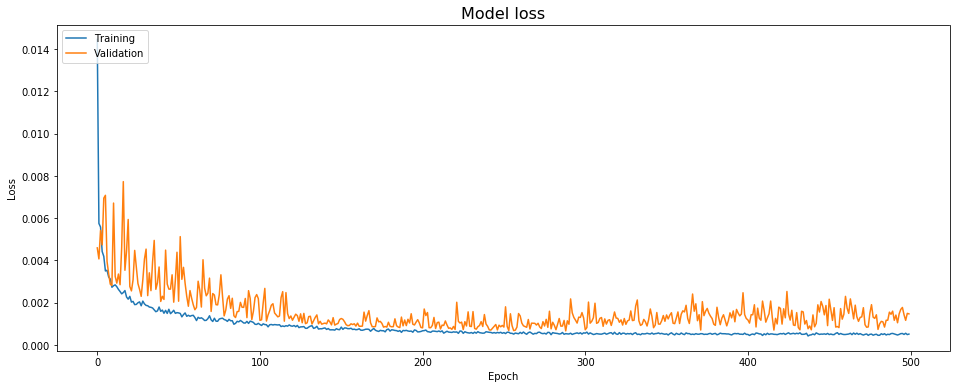

In [21]:
# plot the model loss
plt.figure(figsize=(16,6))
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [22]:
# load the best network weights
filename = "Stock_Prediction_LSTM_weights-0.0007- 257.hdf5"
model.load_weights(filename)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (10, 60, 5)               0         
_________________________________________________________________
lstm_1 (LSTM)                (10, 192)                 152064    
_________________________________________________________________
dropout_1 (Dropout)          (10, 192)                 0         
_________________________________________________________________
dense_1 (Dense)              (10, 32)                  6176      
_________________________________________________________________
dense_2 (Dense)              (10, 1)                   33        
Total params: 158,273
Trainable params: 158,273
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_pred = model.predict(X_train, batch_size)
train_pred_org = (train_pred * scaler.data_range_[3]) + scaler.data_min_[3] 
y_train_org = (y_train * scaler.data_range_[3]) + scaler.data_min_[3] 

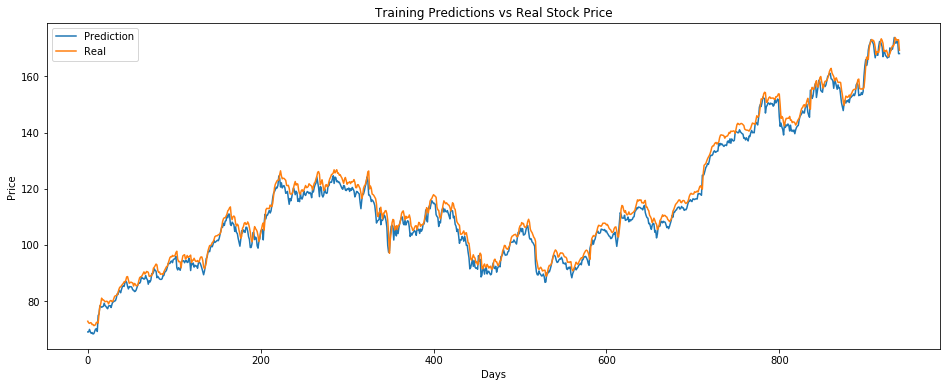

In [24]:
# Visualize the training predictions
plt.figure(figsize=(16,6))
plt.plot(y_train_org)
plt.plot(train_pred_org)
plt.title('Training Predictions vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [25]:
# predict model results on test set and reverse scale outputs
y_pred = model.predict(X_test, batch_size)
y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3] 
y_test_org = (y_test * scaler.data_range_[3]) + scaler.data_min_[3] 

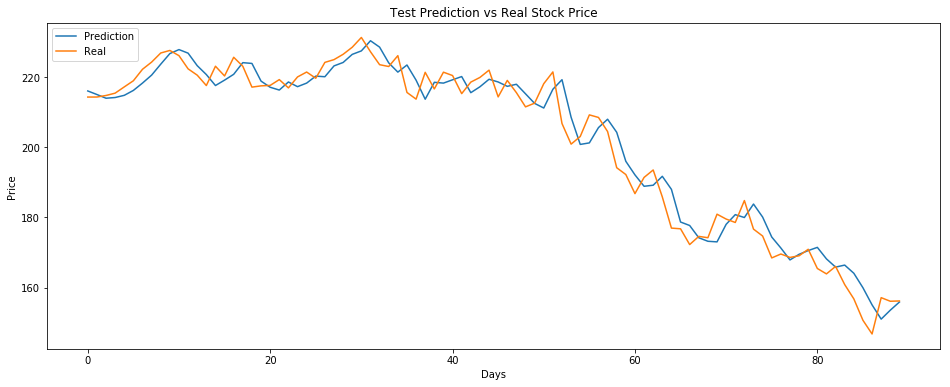

In [26]:
# Visualize the test set predictions
plt.figure(figsize=(16,6))
plt.plot(y_pred_org, label='Prediction')
plt.plot(y_test_org, label='Real')
plt.title('Test Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [27]:
# make a prediction of the next stock price
X = X_test[-10:]
yhat = model.predict(X, batch_size=batch_size)
prediction = (yhat[0,0] * scaler.data_range_[3]) + scaler.data_min_[3] 
print("The prediction for the next stock price is $%.2f" % round(prediction, 2))

The prediction for the next stock price is $171.49
